In [1]:
# Import required libraries
import numpy as np
from scipy.linalg import expm, logm, sqrtm
import matplotlib.pyplot as plt
import h5py
import os
import seaborn as sns
import pandas as pd
from qutip import fidelity,Qobj
# Working directories
script_dir = os.path.dirname(os.path.realpath("__file__"))
data_dir = script_dir#os.path.join(script_dir, 'Data/')
graphs_dir = os.path.join(script_dir, 'Graphs/')

In [2]:
def fidelity_diy(rho,sigma):
    rho_sqrt = sqrtm(rho)
    mat = np.matmul(np.matmul(rho_sqrt, sigma), rho_sqrt)
    F = np.sum(np.sqrt(np.clip(np.linalg.eigh(mat)[0].real, 0, 1))) ** 2
    return F

In [3]:
# Set plotting style
plt.rcParams["figure.figsize"] = (5.3,3)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 600

sns.axes_style("whitegrid")
sns.set_context("paper")
sns.set_palette("rocket")

In [4]:
def read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror, n_shots = None,  p_err = 0.01,format="Kristina"):
    grid_dir = os.path.join(data_dir, "N={}_m={}_model={}_ansatz={}_initialization=random-gaussian_errorChannel={}_p_err={}_entropyMethod={}_optimizer={}_tol_1e-08_nShots={}_seed={}_multierror={}_geom_normal/".format(
            N, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
            m, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
        #
            model,
            ansatz,
            error_channel,
            p_err,
            entropy_method,
            optimizer,
            n_epochs,
            n_fev,
            n_shots,
            seed,
            multierror
        ))
    
    if format == "Kristina":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initialization_random-gaussian"+'__errorChannel_'+str(error_channel)+'__p_err_0.01__entropyMethod_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+'__multierror_'+str(multierror) + "__geom_normal/")
    elif format == "truncSeed":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")
    elif format == "shortend":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "__multiE_no__geom_normal/")
    elif format == "shortendtruncSeed":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_'+str(optimizer)+'__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")

    #'N-'+str(N)+'--m-'+str(m)+'--model-'+str(model)+'--ansatz-'+str(ansatz)+"--initialization-random-gaussian"+'--errorChannel-'+str(error_channel)+'--p_err-0.01--entropyMethod-'+str(entropy_method)+'--optimizer-L-BFGS-B--tol-1e-08--nShots-None--seed-'+str(seed)+'--multierror-'+str(multierror) + "--geom-normal/")
    
    hdf5_files = [f for f in os.listdir(grid_dir) if not f.endswith('.txt')]
    data = []
    
    for file_num, filename in enumerate(hdf5_files): 
        #print(filename)
        f = h5py.File(grid_dir + str(filename), 'r')
        
        row = []
        for grp in f.keys():
            settings = f[grp].attrs['Settings']
            #print(settings)
            beta = grp
            if format != "shortendtruncSeed":
                F_best = f[grp]['F'].attrs['F_best'] 
                F_last = f[grp]['F'][:][-1]
            
            row.append(beta) 
            row.append(N)
            row.append(m)
            row.append(model)
            row.append(ansatz) 
            row.append(error_channel) 
            row.append(entropy_method) 
            row.append(optimizer) 
            row.append(n_epochs)
            row.append(n_fev) 
            row.append(seed) 
            row.append(multierror) 
            #row.append(float(F_best))
            row.append(float(F_last))
            
            rho_target = f[grp]['rho_target'][:]
            rho_final = f[grp]['rho_final'][:]
            S_cross = np.real(-np.trace(np.dot(rho_final, logm(rho_target))))
            #print(S_cross)
            S_target = np.real(-np.trace(np.dot(rho_target, logm(rho_target))))
            #print(S_target)
            S_cross_scaled = S_cross / S_target
            S_cross_diff = np.abs(S_cross - S_target)
            
            row.append(float(S_cross_scaled))
            row.append(float(S_cross_diff))
            #print(S_cross_scaled)
            #print(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))))
                  
            #S_HS = np.trace(np.dot(rho_final, rho_target)) / np.max(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))), np.real(np.trace(np.linalg.matrix_power(rho_target, 2))))
            #print(S_HS)
            
            TD = np.trace(sqrtm(np.linalg.matrix_power(rho_final - rho_target, 2))) / 2
            
            row.append(np.real(TD))
            row.append(np.shape(f[grp]['F'][:])[0])
            row.append(f[grp]["G"][-1])
            """Beta_arr
            if not f[grp]["G"]:
                row.append(f[grp]["G"][-1])
            else:
                row.append(0)
            """
            data.append(row)
            
    df = pd.DataFrame(np.array(data), columns=['beta', 'N', 'm', 'model', 'ansatz', 'error_channel', 'entropy_method', 'optimizer', 'n_epochs', 'n_fev', 'seed', 'multierror', 'F', 'S_cross', 'S_cross_diff', 'TD',"Nit","FinalCost"])#
    return df
def read_dataS(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror, n_shots = None,  p_err = 0.01,format = "Kristina"):
    grid_dir = os.path.join(data_dir, "N={}_m={}_model={}_ansatz={}_initialization=random-gaussian_errorChannel={}_p_err={}_entropyMethod={}_optimizer={}_tol_1e-08_nShots={}_seed={}_multierror={}_geom_normal/".format(
            N, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
            m, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
        #
            model,
            ansatz,
            error_channel,
            p_err,
            entropy_method,
            optimizer,
            n_epochs,
            n_fev,
            n_shots,
            seed,
            multierror
        ))
    if format == "Kristina":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initialization_random-gaussian"+'__errorChannel_'+str(error_channel)+'__p_err_0.01__entropyMethod_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+'__multierror_'+str(multierror) + "__geom_normal/")
    elif format == "truncSeed":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")
    elif format == "shortend":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "__multiE_no__geom_normal/")
    
    #grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initialization_random-gaussian"+'__errorChannel_'+str(error_channel)+'__p_err_0.01__entropyMethod_'+str(entropy_method)+"__seed_"+str(seed)+ "/")
    
    #'N-'+str(N)+'--m-'+str(m)+'--model-'+str(model)+'--ansatz-'+str(ansatz)+"--initialization-random-gaussian"+'--errorChannel-'+str(error_channel)+'--p_err-0.01--entropyMethod-'+str(entropy_method)+'--optimizer-L-BFGS-B--tol-1e-08--nShots-None--seed-'+str(seed)+'--multierror-'+str(multierror) + "--geom-normal/")
    
    hdf5_files = [f for f in os.listdir(grid_dir) if not f.endswith('.txt')]
    data = []
    
    for file_num, filename in enumerate(hdf5_files): 
        #print(filename)
        f = h5py.File(grid_dir + str(filename), 'r')
        
        row = []
        for grp in f.keys():
            settings = f[grp].attrs['Settings']
            #print(settings)
            beta = grp
            F_best = f[grp]['F'].attrs['F_best'] 
            F_last = f[grp]['F'][:][-1]
            
            row.append(beta) 
            row.append(N)
            row.append(m)
            row.append(model)
            row.append(ansatz) 
            row.append(error_channel) 
            row.append(entropy_method) 
            row.append(optimizer) 
            row.append(n_epochs)
            row.append(n_fev) 
            row.append(seed) 
            row.append(multierror) 
            #row.append(float(F_best))
            row.append(float(F_last))
            
            rho_target = f[grp]['rho_target'][:]
            rho_final = f[grp]['rho_final'][:]
            S_cross = np.real(-np.trace(np.dot(rho_final, logm(rho_target))))
            #print(S_cross)
            S_target = np.real(-np.trace(np.dot(rho_target, logm(rho_target))))
            #print(S_target)
            S_cross_scaled = S_cross / S_target
            S_cross_diff = np.abs(S_cross - S_target)
            
            row.append(float(S_cross_scaled))
            row.append(float(S_cross_diff))
            #print(S_cross_scaled)
            #print(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))))
                  
            #S_HS = np.trace(np.dot(rho_final, rho_target)) / np.max(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))), np.real(np.trace(np.linalg.matrix_power(rho_target, 2))))
            #print(S_HS)
            
            TD = np.trace(sqrtm(np.linalg.matrix_power(rho_final - rho_target, 2))) / 2
            
            row.append(np.real(TD))
            row.append(np.shape(f[grp]['F'][:])[0])
            
            
            data.append(row)
            
    df = pd.DataFrame(np.array(data), columns=['beta', 'N', 'm', 'model', 'ansatz', 'error_channel', 'entropy_method', 'optimizer', 'n_epochs', 'n_fev', 'seed', 'multierror', 'F', 'S_cross', 'S_cross_diff', 'TD',"Nit"])
    return df
def read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror, n_shots = None,  p_err = 0.01,format="Kristina"):
    grid_dir = os.path.join(data_dir, "N={}_m={}_model={}_ansatz={}_initialization=random-gaussian_errorChannel={}_p_err={}_entropyMethod={}_optimizer={}_tol_1e-08_nShots={}_seed={}_multierror={}_geom_normal/".format(
            N, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
            m, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
        #
            model,
            ansatz,
            error_channel,
            p_err,
            entropy_method,
            optimizer,
            n_epochs,
            n_fev,
            n_shots,
            seed,
            multierror
        ))
    
    if format == "Kristina":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initialization_random-gaussian"+'__errorChannel_'+str(error_channel)+'__p_err_0.01__entropyMethod_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+'__multierror_'+str(multierror) + "__geom_normal/")
    elif format == "truncSeed":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")
    elif format == "shortend":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "__multiE_no__geom_normal/")
    elif format == "shortendtruncSeed":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_'+str(optimizer)+'__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")
    elif format == "GPU":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_'+str(optimizer)+'__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")
      
    #'N-'+str(N)+'--m-'+str(m)+'--model-'+str(model)+'--ansatz-'+str(ansatz)+"--initialization-random-gaussian"+'--errorChannel-'+str(error_channel)+'--p_err-0.01--entropyMethod-'+str(entropy_method)+'--optimizer-L-BFGS-B--tol-1e-08--nShots-None--seed-'+str(seed)+'--multierror-'+str(multierror) + "--geom-normal/")
    
    hdf5_files = [f for f in os.listdir(grid_dir) if not f.endswith('.txt')]
    data = []
    
    for file_num, filename in enumerate(hdf5_files): 
        #print(filename)
        f = h5py.File(grid_dir + str(filename), 'r')
        
        row = []
        for grp in f.keys():
            settings = f[grp].attrs['Settings']
            #print(settings)
            beta = grp

            
            row.append(beta) 
            row.append(N)
            row.append(m)
            row.append(model)
            row.append(ansatz) 
            row.append(error_channel) 
            row.append(entropy_method) 
            row.append(optimizer) 
            row.append(n_epochs)
            row.append(n_fev) 
            row.append(seed) 
            row.append(multierror) 
            rho_target = f[grp]['rho_target'][:]
            rho_final = f[grp]['rho_final'][:]

            if format != "GPU":
                F_best = f[grp]['F'].attrs['F_best'] 
                F_last = f[grp]['F'][:][-1]
                #row.append(float(F_best))
                row.append(float(F_last))
                print(float(fidelity(Qobj(rho_target),Qobj(rho_final))),float(F_last),fidelity_diy(rho_target,rho_final))
            else: row.append(float(fidelity(Qobj(rho_target),Qobj(rho_final))))
            
            S_cross = np.real(-np.trace(np.dot(rho_final, logm(rho_target))))
            #print(S_cross)
            S_target = np.real(-np.trace(np.dot(rho_target, logm(rho_target))))
            #print(S_target)
            S_cross_scaled = S_cross / S_target
            S_cross_diff = np.abs(S_cross - S_target)
            
            row.append(float(S_cross_scaled))
            row.append(float(S_cross_diff))
            #print(S_cross_scaled)
            #print(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))))
                  
            #S_HS = np.trace(np.dot(rho_final, rho_target)) / np.max(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))), np.real(np.trace(np.linalg.matrix_power(rho_target, 2))))
            #print(S_HS)
            
            TD = np.trace(sqrtm(np.linalg.matrix_power(rho_final - rho_target, 2))) / 2
            
            row.append(np.real(TD))
            if format != "GPU": row.append(np.shape(f[grp]['F'][:])[0])
        
            row.append(f[grp]["G"][-1])
            """Beta_arr
            if not f[grp]["G"]:
                row.append(f[grp]["G"][-1])
            else:
                row.append(0)
            """
            data.append(row)
            
    if format != "GPU": df = pd.DataFrame(np.array(data), columns=['beta', 'N', 'm', 'model', 'ansatz', 'error_channel', 'entropy_method', 'optimizer', 'n_epochs', 'n_fev', 'seed', 'multierror', 'F', 'S_cross', 'S_cross_diff', 'TD',"Nit","FinalCost"])#
    else: df = pd.DataFrame(np.array(data), columns=['beta', 'N', 'm', 'model', 'ansatz', 'error_channel', 'entropy_method', 'optimizer', 'n_epochs', 'n_fev', 'seed', 'multierror', 'F', 'S_cross', 'S_cross_diff', 'TD',"FinalCost"])#
    
    return df

In [8]:
def create_data_frame(frames):
    df = pd.concat(frames, ignore_index=True)

    df['beta']= df['beta'].astype(float)
    df['N']= df['N'].astype(int)
    df['m']= df['m'].astype(int)
    df['model']= df['model'].astype(str)
    df['ansatz']= df['ansatz'].astype(str)
    df['error_channel']= df['error_channel'].astype(str)
    df['entropy_method']= df['entropy_method'].astype(str)
    df['optimizer']= df['optimizer'].astype(str)
    df['n_epochs']= df['n_epochs'].astype(str)
    df['n_fev']= df['n_fev'].astype(str)
    df['seed']= df['seed'].astype(int)
    df['multierror']= df['multierror'].astype(str)
    df['F']= df['F'].astype(float)
    df['S_cross']= df['S_cross'].astype(float)
    
    df['S_cross_diff']= df['S_cross_diff'].astype(float)
    df['TD']= df['TD'].astype(float)
    
    


    return df
def create_data_frame(frames):
        df = pd.concat(frames, ignore_index=True)

        df['beta']= df['beta'].astype(float)
        df['N']= df['N'].astype(int)
        df['m']= df['m'].astype(int)
        df['model']= df['model'].astype(str)
        df['ansatz']= df['ansatz'].astype(str)
        df['error_channel']= df['error_channel'].astype(str)
        df['entropy_method']= df['entropy_method'].astype(str)
        df['optimizer']= df['optimizer'].astype(str)
        df['n_epochs']= df['n_epochs'].astype(str)
        df['n_fev']= df['n_fev'].astype(str)
        df['seed']= df['seed'].astype(int)
        df['multierror']= df['multierror'].astype(str)
        df['F']= df['F'].astype(float)
        df['S_cross']= df['S_cross'].astype(float)
        
        df['S_cross_diff']= df['S_cross_diff'].astype(float)
        df['TD']= df['TD'].astype(float)
        df['Nit']= df['Nit'].astype(float)
        df['FinalCost']= df['FinalCost'].astype(float)

        return df
def create_data_frame_GPU(frames):
        df = pd.concat(frames, ignore_index=True)

        df['beta']= df['beta'].astype(float)
        df['N']= df['N'].astype(int)
        df['m']= df['m'].astype(int)
        df['model']= df['model'].astype(str)
        df['ansatz']= df['ansatz'].astype(str)
        df['error_channel']= df['error_channel'].astype(str)
        df['entropy_method']= df['entropy_method'].astype(str)
        df['optimizer']= df['optimizer'].astype(str)
        df['n_epochs']= df['n_epochs'].astype(str)
        df['n_fev']= df['n_fev'].astype(str)
        df['seed']= df['seed'].astype(int)
        df['multierror']= df['multierror'].astype(str)
        df['F']= df['F'].astype(float)
        df['S_cross']= df['S_cross'].astype(float)
        
        df['S_cross_diff']= df['S_cross_diff'].astype(float)
        df['TD']= df['TD'].astype(float)

        df['FinalCost']= df['FinalCost'].astype(float)

        return df

In [6]:
Beta_arr = [1e-2, 0.05,0.1,0.25,0.5,0.75,1,2,5,10]#np.logspace
#Beta_arr = Beta_arr[5:]
Seed_arr = [1,2,3,4,5]
#! !python -W ignore main.py  -N 3 -m 2 -model HDm2  -ansatz Hmultic  -initialization random-gaussian -error_channel phaseflip  -p_err 0.01 -entropy_method exact -optimizer L-BFGS-B -tol 1e-08 -seed S  -lambdas B

## Compare ansatz that uses multiqubit nonunitary operations to one that just uses single qubit nonunitry operations

In [10]:
frames = []

N_list = [6]
m_list = [3,6]
model_list = ["Heisenberg"]
ansatz_list = ["qaoa-r-layers","Hmultic_RS","Hmultic_R"]#,"Hmultic_RS" #"Hmultic"#made a special ansatz so that I did not have to change the running one. 
error_channel_list = ["phaseflip","bitflip"]
entropy_method_list = ["approx-D"]
optimizer_list = ["L-BFGS-B"]
n_epochs_list = [50]
n_fev_list = [10000]
seeds = [1,2,3,4,5,6,7,8,9,10]
multierror_list = ["no"]

for N in N_list:
    for m in m_list:
        #if m    
            for model in model_list:
                for ansatz in ansatz_list:
                    for error_channel in error_channel_list:
                        for entropy_method in entropy_method_list:
                            for optimizer in optimizer_list:
                                for n_epochs in n_epochs_list:
                                    for n_fev in n_fev_list:
                                        for seed in seeds:
                                            for multierror in multierror_list:
                                                if m == 3:
                                                    if error_channel!="bitflip": #ansatz != "Hmultic_3":
                                                            frames.append(read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror,format="shortendtruncSeed"))
                                                    elif ansatz == "qaoa-r-layers":
                                                              frames.append(read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror,format="shortendtruncSeed"))
                                                    
                                                    """elif seed <= 5:
                                                            frames.append(read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror,format="shortendtruncSeed"))"""
                                                   
                                                if m == 6 and ansatz == "qaoa-r-layers" and error_channel!="bitflip":
                                                        frames.append(read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror,format="shortendtruncSeed"))
                                                
df = create_data_frame(frames)




0.8978138894339762 0.8060697807222083 0.806069780060653
0.9960310303035567 0.9920778133194715 0.9920778133275666
0.9879910570805943 0.9761263289153026 0.9761263288712315
0.902951753670901 0.8153218687371888 0.8153218750203469
0.9911062265915644 0.9822902273113473 0.9822985220852988
0.9368852675270173 0.8777540107657592 0.8777540440618239
0.9999811108704751 0.9999616720073157 0.9999799843692442
0.9346800931316179 0.873626876739121 0.8736268764965314
0.9999952454045766 0.9999865228325666 1.0000232303445977
0.9011295453491229 0.8120344582007002 0.8120344575021888
0.9928338498743328 0.9857190535034401 0.9857190534562906
0.9773124389582283 0.9551396033323803 0.9551396033424812
0.9042470373629946 0.8176627050834491 0.8176627047565604
0.9908598319443249 0.9817990244524925 0.9817997322715233
0.9380837292223404 0.8800010785315389 0.880001091957312
0.9999809895354481 0.9999618625847367 0.9999931924212311
0.9456662744092664 0.8942847028709427 0.8942847025551038
0.999996319614077 0.999992494736638

      beta  N  m       model         ansatz error_channel entropy_method  \
280   0.01  6  3  Heisenberg      Hmultic_R     phaseflip       approx-D   
207   0.01  6  3  Heisenberg     Hmultic_RS     phaseflip       approx-D   
112   0.01  6  3  Heisenberg  qaoa-r-layers       bitflip       approx-D   
363   0.01  6  6  Heisenberg  qaoa-r-layers     phaseflip       approx-D   
279   0.05  6  3  Heisenberg      Hmultic_R     phaseflip       approx-D   
234   0.05  6  3  Heisenberg     Hmultic_RS     phaseflip       approx-D   
82    0.05  6  3  Heisenberg  qaoa-r-layers     phaseflip       approx-D   
411   0.05  6  6  Heisenberg  qaoa-r-layers     phaseflip       approx-D   
290   0.10  6  3  Heisenberg      Hmultic_R     phaseflip       approx-D   
227   0.10  6  3  Heisenberg     Hmultic_RS     phaseflip       approx-D   
47    0.10  6  3  Heisenberg  qaoa-r-layers     phaseflip       approx-D   
421   0.10  6  6  Heisenberg  qaoa-r-layers     phaseflip       approx-D   
309   0.25  

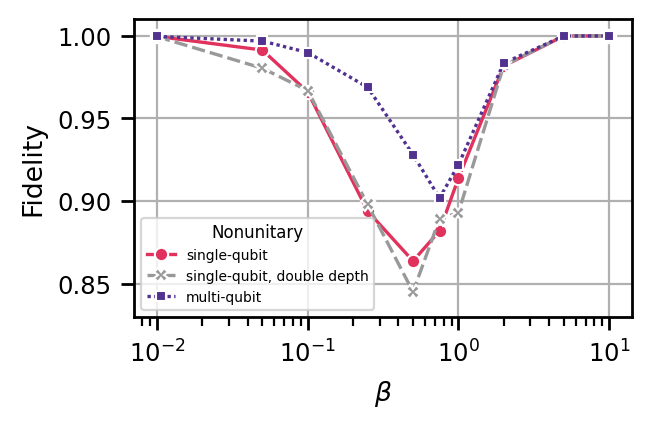

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams["figure.figsize"] = (170/2/25.4, (2/3)*170/2/25.4)  # Conversion from mm to inches
plt.rcParams.update({'font.size': 6})

sns.axes_style("whitegrid")
sns.set_context("paper")
sns.set_palette("rocket_r",2)

fig = plt.figure()

beta_arr = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10]
df_max = df.loc[df.groupby(['beta', 'ansatz',"m"])['FinalCost'].idxmin()]
df_max = df_max[df_max['beta'].isin(beta_arr)]
print(df_max)
# Create new DataFrame with specified values
df_filtered1 = df_max[(df_max['ansatz'] == 'qaoa-r-layers') & ((df_max['m'] == 3) | (df_max['m'] == 6))]

df_filtered2 = df_max[df_max['ansatz'] == 'Hmultic_R']

df_filtered = pd.concat([df_filtered1, df_filtered2])

# Update labels
label_map = {('qaoa-r-layers', 3): 'single-qubit', ('qaoa-r-layers', 6): 'single-qubit, double depth', 'Hmultic_R': 'multi-qubit'}
df_filtered['label'] = df_filtered.apply(lambda row: label_map[(row['ansatz'], row['m'])] if (row['ansatz'], row['m']) in label_map else label_map[row['ansatz']], axis=1)

# Colors and linestyles
colors = {"approx-D":"#E1325D" , "disentangle": "#513291","exact":"#3F3F43"}
#colors = {'single-qubit': "#774360", 'single-qubit, double depth': '#999999', 'multi-qubit': '#776666'}
colors = {'single-qubit': "#E1325D", 'single-qubit, double depth': '#999999', 'multi-qubit': "#513291"}
linestyles = {'single-qubit': "-", 'single-qubit, double depth': "--", 'multi-qubit': "-."}

ax = sns.lineplot(data = df_filtered, x = 'beta', y ='F', markers = True, style="label", hue="label", legend = True, palette=colors)

legend = ax.legend( fontsize=5, loc='lower left')
legend.set_title('Nonunitary', prop={'size': 6})
plt.xscale('log')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')
plt.grid()
plt.ylim((0.83,1.01))
plt.tight_layout()


filename = "Comparing_Multi_phase_Heisenberg_approx-D.png"
#plt.savefig(graphs_dir + filename,  facecolor=fig.get_facecolor()  ,bbox_inches='tight')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/eliaszap/polybox - Elias Zapusek (zapuseke@phys.ethz.ch)@polybox.ethz.ch/Phd/QML/VQT/VQT/Fig8 Heisenberg/Graphs/Comparing_Nit_symmetric_HmulticRsvs_R.png'

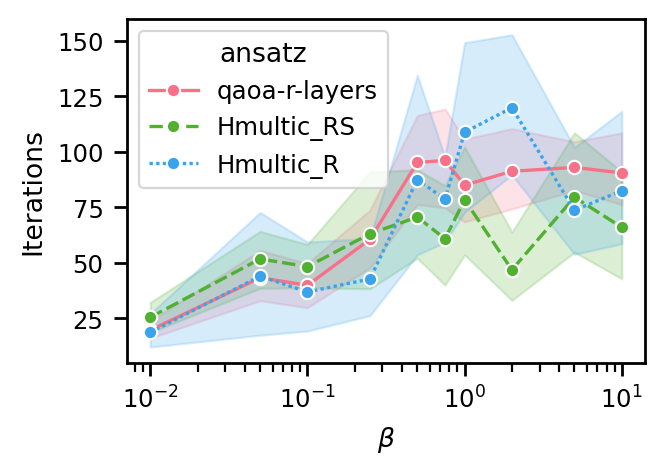

In [13]:
sns.lineplot(data = df, x = 'beta', y ='Nit', style="ansatz", marker="o",hue="ansatz",sort=True)

plt.xscale('log')
#plt.yticks(np.arange(14, 74, step=10))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Iterations')
plt.savefig(graphs_dir + "Comparing_Nit_symmetric_HmulticRsvs_R",  facecolor=fig.get_facecolor()  ,bbox_inches='tight')
plt.show()

In [ ]:
from matplotlib.colors import to_rgba

# Get the "rocket" palette as a list of RGB tuples
rocket_palette = sns.color_palette("rocket")

# Create a dict of the palette where the keys are the color names and the values are the RGB tuples
rocket_dict = dict(zip(["rocket_{}".format(i) for i in ['r','o','y','g','b','p']], [to_rgba(color) for color in rocket_palette]))

print(rocket_dict.keys())
print(sns.color_palette("rocket"))

dict_keys(['rocket_r', 'rocket_o', 'rocket_y', 'rocket_g', 'rocket_b', 'rocket_p'])
[(0.20973515, 0.09747934, 0.24238489), (0.43860848, 0.12177004, 0.34119475), (0.67824099, 0.09192342, 0.3504148), (0.8833417, 0.19830556, 0.26014181), (0.95381595, 0.46373781, 0.31769923), (0.96516917, 0.70776351, 0.5606593)]


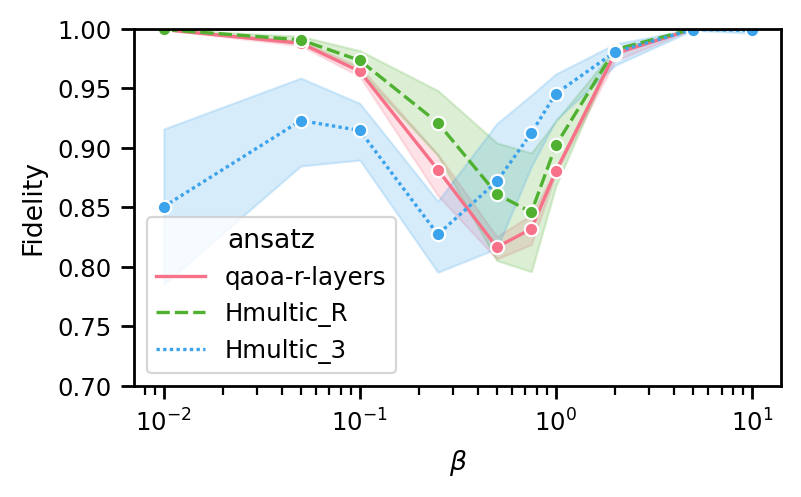

In [ ]:

######################Remove the one datapouint as I have a very low fidelity #############################
dfdrop = df.where(df["F"]>0.7)#df.drop(where: df["F"]<0.72)
#dfdrop = dfdrop.drop(np.argmin(dfdrop.F))
#dfdrop = dfdrop.drop(195)
#dfdrop = dfdrop.drop(167)



# plot
sns.lineplot(data = dfdrop, x = 'beta', y ='F', style="ansatz", marker="o",hue="ansatz",legend =True)

#plt.legend(title='Nonunitary', loc='lower right', labels=['two-qubit', 'single-qubit'])
plt.xscale('log')

plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')

plt.ylim((0.7,1))
#filename = "Comparing_Multi_phase_Heisenberg_approx-D.pdf"
#plt.savefig(graphs_dir + filename, facecolor=fig.get_facecolor() , bbox_inches='tight')
plt.show()